In [2]:
import timm
import torch

from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from timm.layers import SwiGLUPacked
from PIL import Image

# need to specify MLP layer and activation function for proper init
model = timm.create_model("hf-hub:paige-ai/Virchow2", pretrained=True, mlp_layer=SwiGLUPacked, act_layer=torch.nn.SiLU)
model = model.eval()

transforms = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))
processor = transforms

# model = AutoModel.from_pretrained("histai/hibou-b", trust_remote_code=True)

In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spatialdata_plot
import spatialdata as sd
import scanpy as sc
import os


In [4]:
sdata = sd.read_zarr("data/UC1_NI.zarr")
sdata

/Users/joseangelcazarestorres/.pyenv/versions/3.12.6/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: /Users/joseangelcazarestorres/Desktop/MIT - Assignments/4 Senior/Fall/6.8701/MLCB_immune/notebooks/data/UC1_NI.zarr
├── Images
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 21000, 22000)
│     └── 'HE_original': DataArray[cyx] (3, 21000, 22000)
└── Tables
      ├── 'anucleus': AnnData (80037, 460)
      └── 'cell_id-group': AnnData (93686, 0)
with coordinate systems:
    ▸ 'global', with elements:
        HE_nuc_original (Images), HE_original (Images)

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.034188036..1.0].


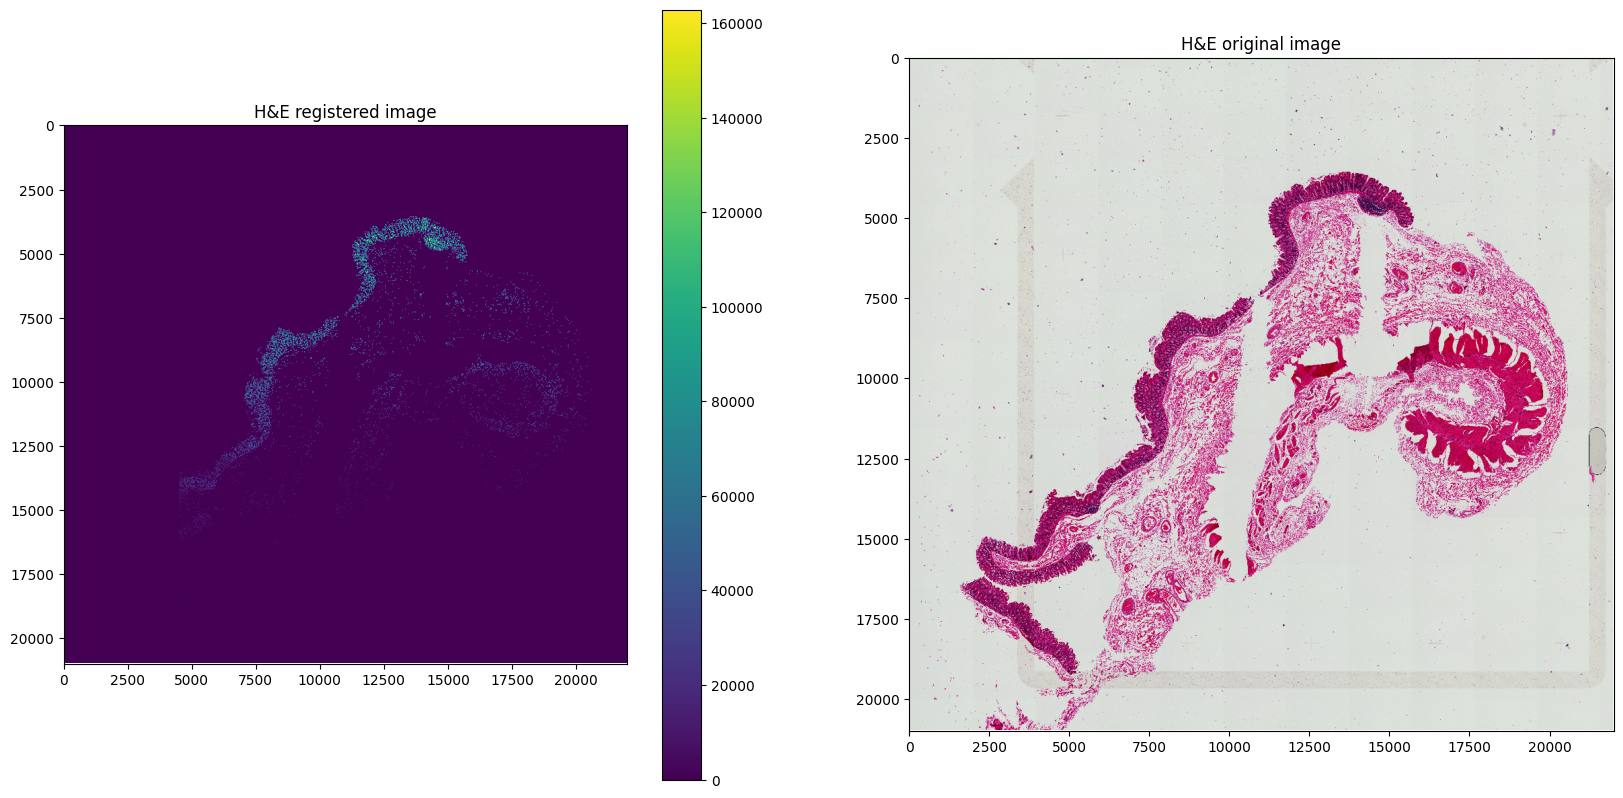

In [5]:
##  H&E pathology image
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the axes to easily index them

sdata.pl.render_images("HE_nuc_original").pl.show(ax=axes[0], title="H&E registered image", coordinate_systems="global")
sdata.pl.render_images("HE_original").pl.show(ax=axes[1], title="H&E original image", coordinate_systems="global")

In [6]:
## Get the list of gene concerned in crunch 1
gene_name_list = sdata['anucleus'].var['gene_symbols'].values
x_count = pd.DataFrame(sdata['anucleus'].layers['counts'], columns=gene_name_list) # raw count data
x_norm = pd.DataFrame((sdata['anucleus'].X), columns=gene_name_list) # normalized data

## Selecting training cells
cell_id_example = sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'train']['cell_id'].to_numpy()
cell_id_example = list(set(cell_id_example).intersection(set(sdata['anucleus'].obs['cell_id'].unique())))

## Get y from the anucleus data
ground_truth_example = sdata['anucleus'].layers['counts'][sdata['anucleus'].obs['cell_id'].isin(cell_id_example),:]
y = pd.DataFrame(ground_truth_example, columns= gene_name_list, index = cell_id_example)

In [7]:
sdata['cell_id-group'].obs['group'].unique()

array(['train', 'validation', 'test'], dtype=object)

In [8]:
len(cell_id_example)

80037

In [9]:
cell_id_example[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [10]:
cell_id_example[::-1][:10]

[162955,
 162953,
 162952,
 162951,
 162950,
 162949,
 162948,
 162947,
 162945,
 162944]

In [11]:
# get the max and min of cell_id_example
max_cell_id = max(cell_id_example)
min_cell_id = min(cell_id_example)

# print them
print(f"max cell_id: {max_cell_id}")
print(f"min cell_id: {min_cell_id}")


max cell_id: 162955
min cell_id: 1


In [12]:
list(set(sdata['anucleus'].obs['cell_id'].unique()))[-1]

162955

In [13]:
cell_id_valid = sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'validation']['cell_id'].to_numpy()
print(cell_id_valid.shape)
cell_id_valid = list(set(cell_id_valid).intersection(set(sdata['anucleus'].obs['cell_id'].unique())))
print(len(cell_id_valid))
gt_valid = sdata['anucleus'].layers['counts'][sdata['anucleus'].obs['cell_id'].isin(cell_id_valid),:]
print(len(gt_valid))
#y_valid = pd.DataFrame(sdata['anucleus'].layers['counts'][sdata['anucleus'].obs['cell_id'].isin(cell_id_valid),:], columns= gene_name_list, index = cell_id_valid)

(6175,)
0
0


In [14]:
cell_id_test = sdata['cell_id-group'].obs[sdata['cell_id-group'].obs['group'] == 'test']['cell_id'].to_numpy()
print(cell_id_test.shape)
cell_id_test = list(set(cell_id_test).intersection(set(sdata['anucleus'].obs['cell_id'].unique())))
print(len(cell_id_test))
gt_test = sdata['anucleus'].layers['counts'][sdata['anucleus'].obs['cell_id'].isin(cell_id_test),:]
print(len(gt_test))

(7474,)
0
0


In [15]:
ground_truth_example.shape

(80037, 460)

In [16]:
len(cell_id_example)

80037

In [17]:
len(cell_id_example)

80037

In [18]:
np.array(cell_id_example).max()

162955

In [19]:
y.shape

(80037, 460)

In [20]:
sdata['HE_nuc_original'].shape

(1, 21000, 22000)

In [21]:
import numpy as np
from skimage.measure import regionprops
from tqdm import tqdm
import tifffile
import os

def save_cropped_cells(sdata, crop_size=128, out_dir='image_crop'):
    """
    Function to save cropped cell images from the original intensity image.

    Parameters:
    sdata: SpatialData object containing the image data.
    crop_size: Size of the square crop around each cell's centroid.
    out_dir: Directory where the cropped images will be saved.
    """
    # Create output directory if it doesn't exist
    os.makedirs(out_dir, exist_ok=True)

    # Get regions from the nucleus image
    regions = regionprops(sdata['HE_nuc_original'][0, :, :].to_numpy())

    # Get the original intensity image
    intensity_image = sdata['HE_original'].to_numpy()

    # Half of the crop size to calculate boundaries
    half_crop = crop_size // 2

    crop_list = []

    # Loop through each region and extract the crop
    for props in tqdm(regions):
        cell_id = props.label
        centroid = props.centroid
        y_center, x_center = int(centroid[0]), int(centroid[1])

        # Calculate the crop boundaries
        minr, maxr = y_center - half_crop, y_center + half_crop
        minc, maxc = x_center - half_crop, x_center + half_crop

        # Ensure boundaries are within the image dimensions
        pad_top = max(0, -minr)
        minr = max(0, minr)

        pad_bottom = max(0, maxr - intensity_image.shape[1])
        maxr = min(maxr, intensity_image.shape[1])

        pad_left = max(0, -minc)
        minc = max(0, minc)

        pad_right = max(0, maxc - intensity_image.shape[2])
        maxc = min(maxc, intensity_image.shape[2])

        # Crop and pad the image if needed
        if pad_top + pad_bottom + pad_left + pad_right > 0:
            crop = np.pad(intensity_image[:, minr:maxr, minc:maxc],
                          ((0, 0), (pad_top, pad_bottom), (pad_left, pad_right)),
                          mode='constant', constant_values=0)
        else:
            crop = intensity_image[:, minr:maxr, minc:maxc]


        crop_list.append(crop);
        # Save the crop as a TIFF file
        tifffile.imwrite(f"{out_dir}/{cell_id}.tif", crop.astype('uint8'), metadata={'axes': 'CYX'})

    return crop_list

In [22]:
def load_cropped_cells(out_dir='image_crop'):
    """
    Function to load the cropped cell images from the output directory.

    Parameters:
    out_dir: Directory where the cropped images are saved.

    Returns:
    crops: List of cropped cell images.
    """
    crops = []
    # sort the file names 
    files = os.listdir(out_dir)
    files.sort(key=lambda x: int(x.split('.')[0]))
    print(files[:10])

    for file in tqdm(files):
        if file.endswith(".tif"):
            crop = tifffile.imread(f"{out_dir}/{file}")
            crops.append(crop)
    
    return crops

In [23]:
# crop_list = save_cropped_cells(sdata, crop_size = 256)

In [24]:
crop_list = load_cropped_cells()

['1.tif', '2.tif', '3.tif', '4.tif', '5.tif', '6.tif', '7.tif', '8.tif', '9.tif', '10.tif']


100%|██████████| 93686/93686 [00:59<00:00, 1570.56it/s]


In [25]:
out_dir = 'image_crop'
files = os.listdir(out_dir)
files.sort(key=lambda x: int(x.split('.')[0]))

crop_list_ind_to_id = [int(file.split('.')[0]) for file in files] # index to cell_id
crop_list_id_to_ind = {cell_id: i for i, cell_id in enumerate(crop_list_ind_to_id)} # cell_id to index
crop_list_ind_to_id = {i: cell_id for i, cell_id in enumerate(crop_list_ind_to_id)} # index to cell_id

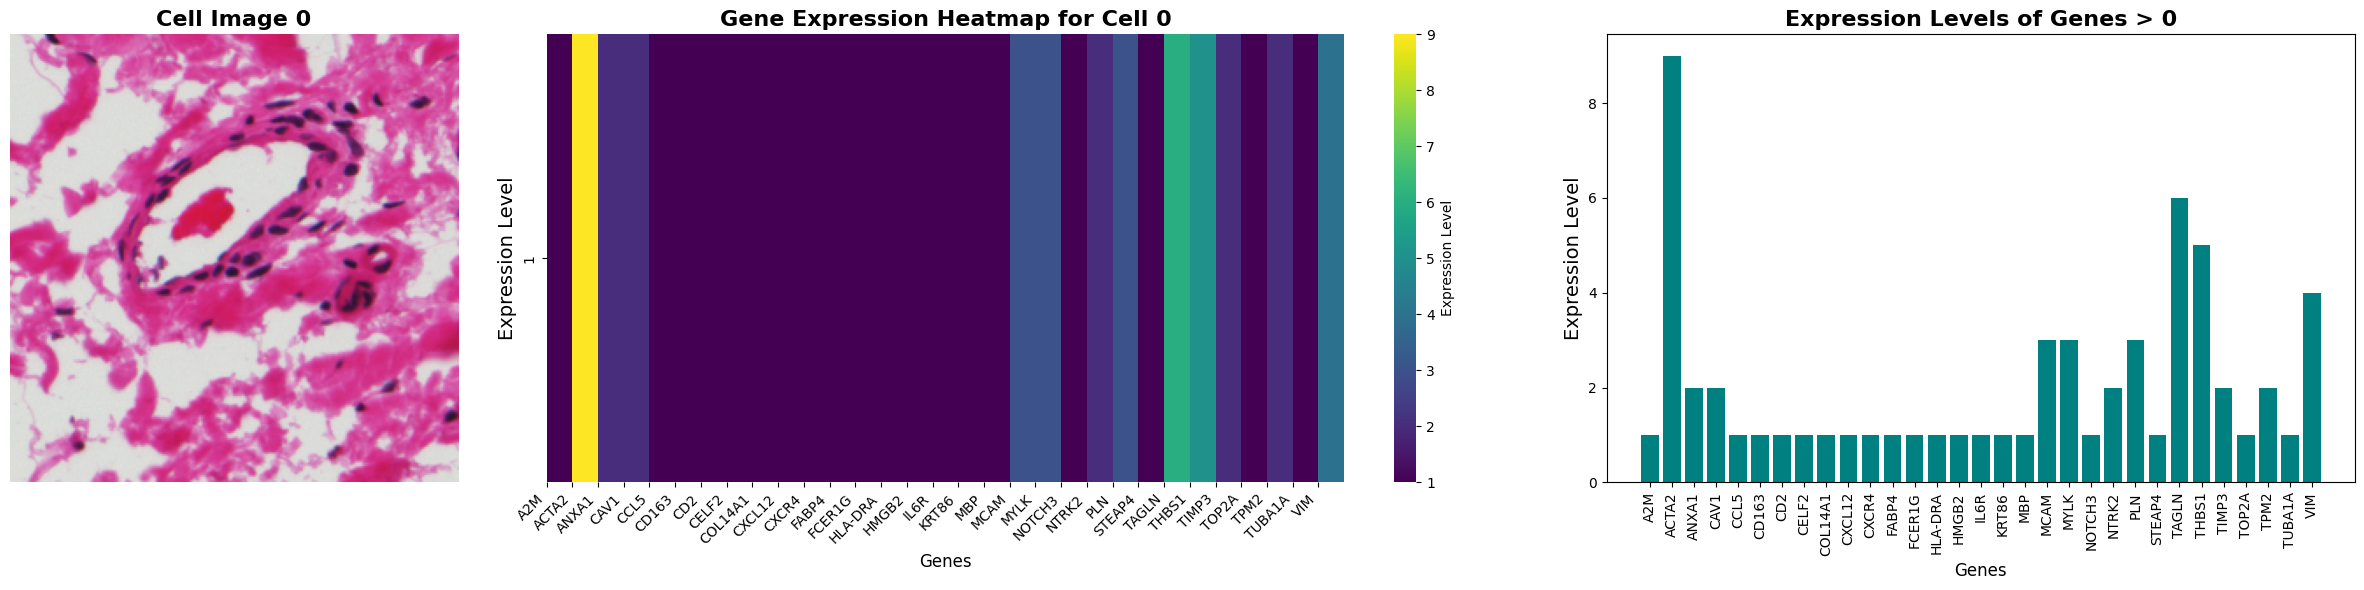

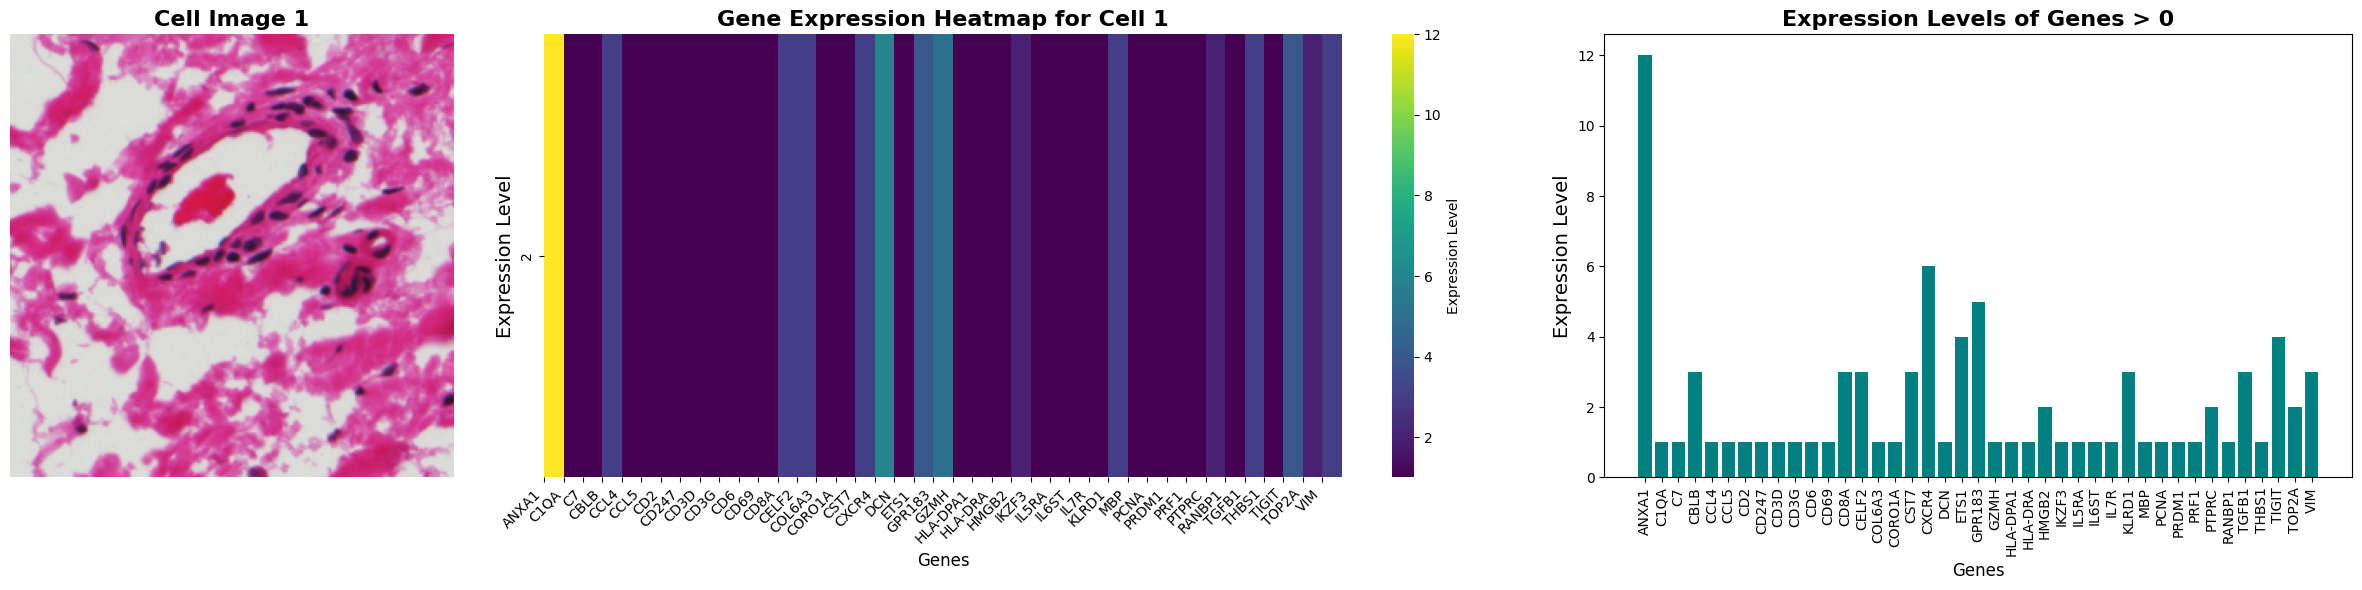

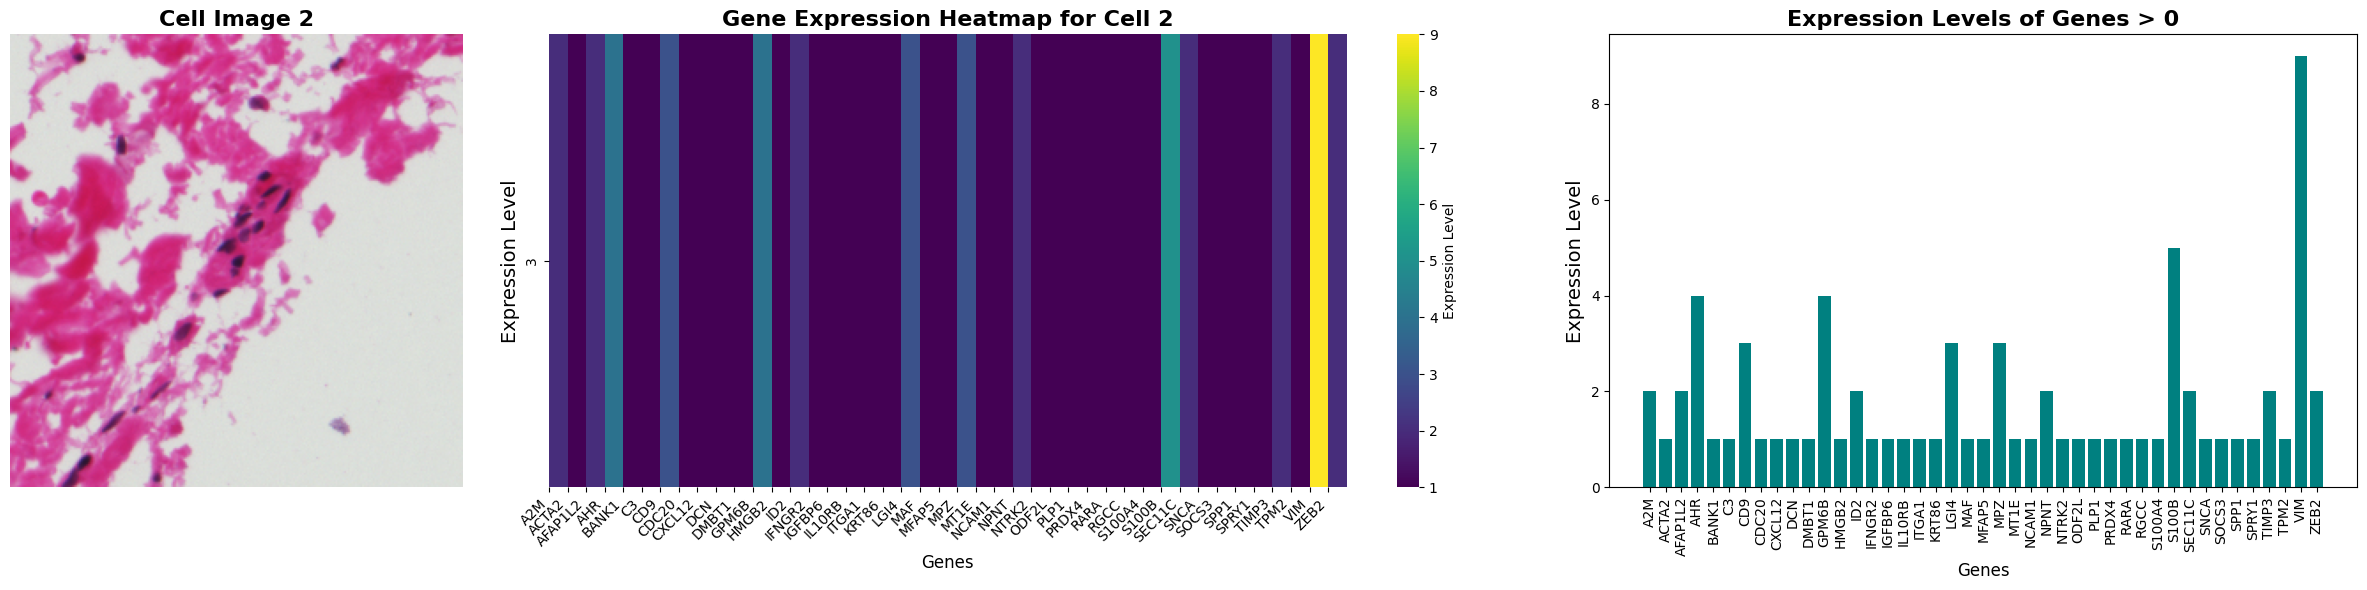

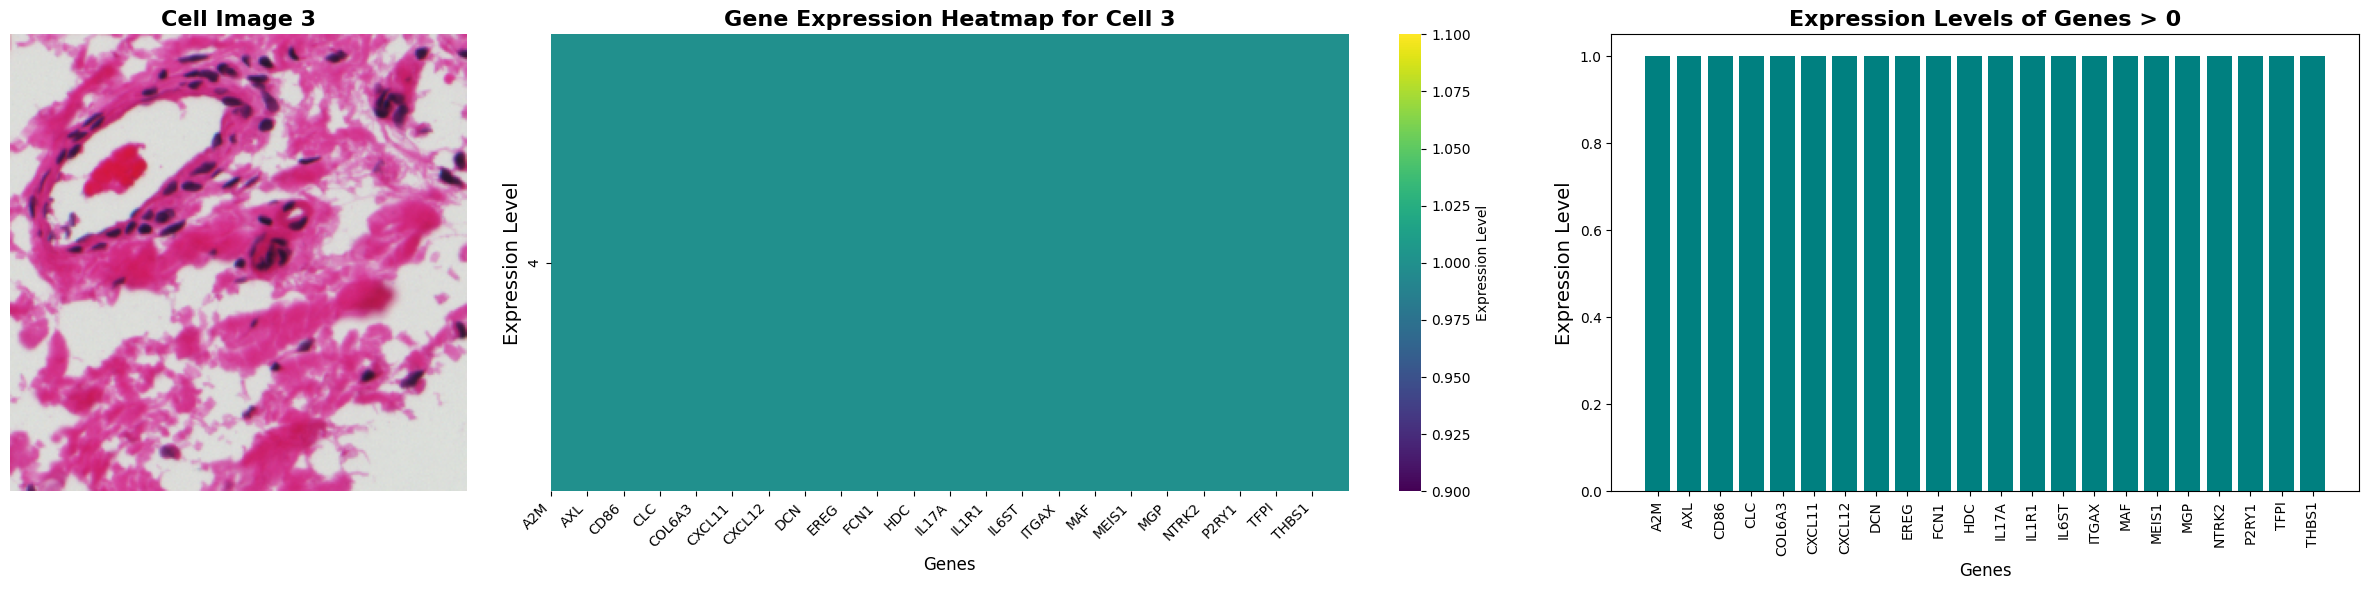

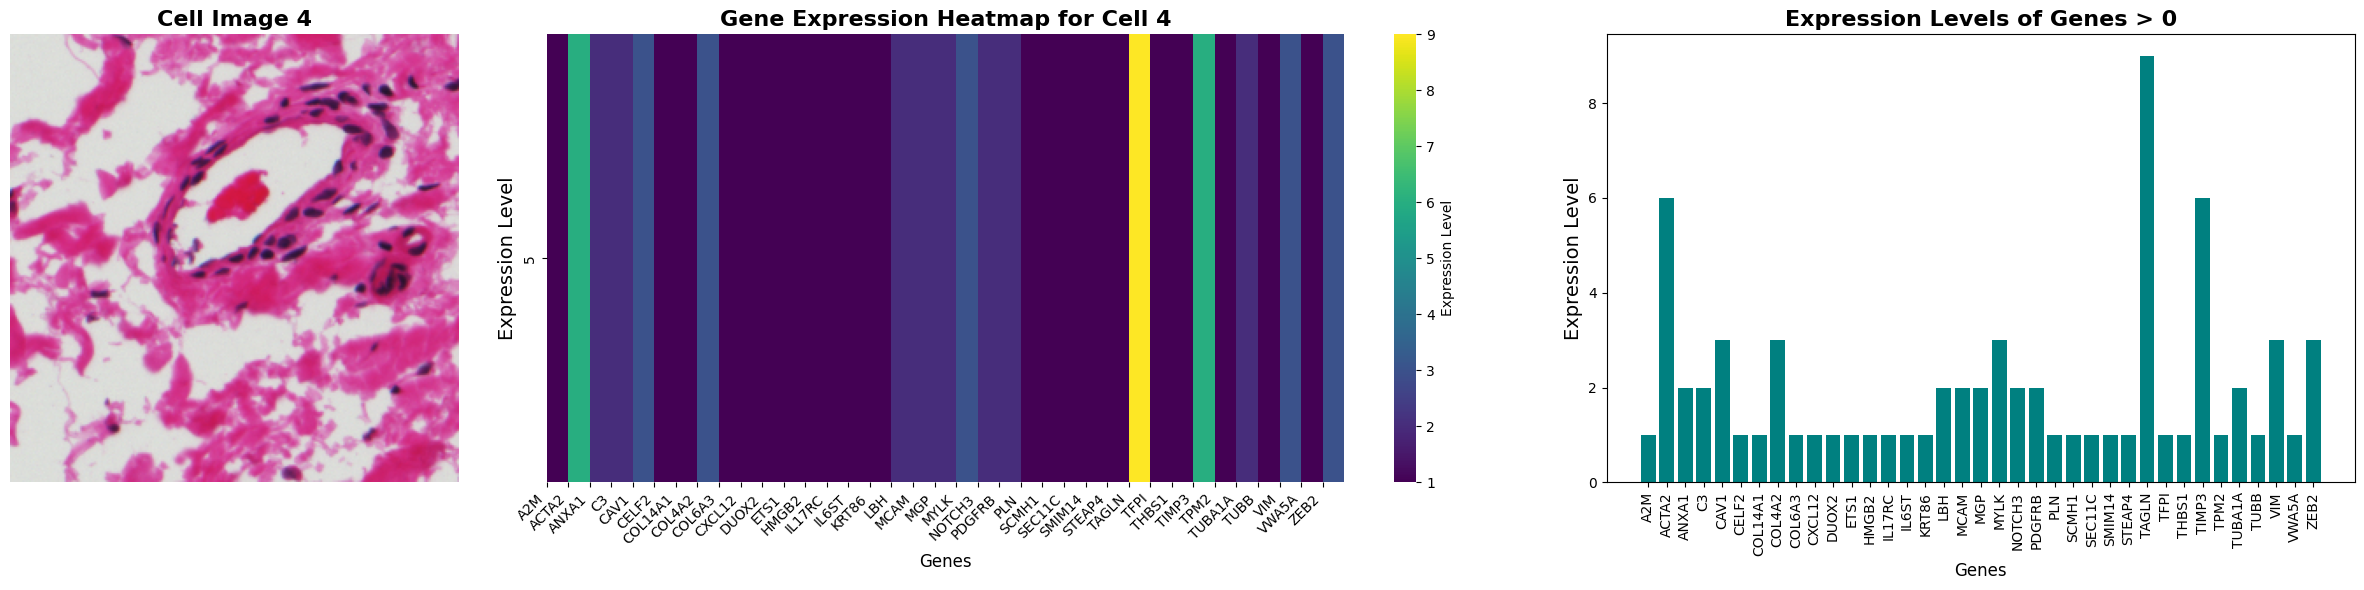

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Loop over the first four cells
for cell_id in range(5):
    # Create a figure with three subplots (image, heatmap, and bar chart)
    fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 2, 1.5]}, figsize=(24, 6))

    # First plot: Image of the cell on the left
    ax[0].imshow(crop_list[cell_id].transpose((1, 2, 0)))
    ax[0].set_title(f'Cell Image {cell_id}', fontsize=16, fontweight='bold')
    ax[0].axis('off')  # Hide axes for image clarity

    # Filter the gene expression data to include only genes with expression > 0
    gene_expression_data = y.iloc[cell_id]
    filtered_data = gene_expression_data[gene_expression_data > 0]
    heatmap_data = pd.DataFrame(filtered_data).transpose()

    # Second plot: Gene Expression Heatmap with filtered genes
    sns.heatmap(
        heatmap_data,
        annot=False,
        cmap='viridis',  # Color map for expression levels
        fmt=".2f",
        ax=ax[1],
        cbar_kws={'label': 'Expression Level'}  # Color bar with label
    )

    # Titles and labels with enhanced readability for heatmap
    ax[1].set_title(f'Gene Expression Heatmap for Cell {cell_id}', fontsize=16, fontweight='bold')
    ax[1].set_xlabel('Genes', fontsize=12)
    ax[1].set_ylabel('Expression Level', fontsize=14)
    ax[1].set_xticks(range(len(filtered_data.index)))
    ax[1].set_xticklabels(filtered_data.index, rotation=45, ha='right', fontsize=10)

    # Third plot: Bar Chart for gene expression levels
    ax[2].bar(filtered_data.index, filtered_data.values, color='teal')
    ax[2].set_title("Expression Levels of Genes > 0", fontsize=16, fontweight='bold')
    ax[2].set_xlabel("Genes", fontsize=12)
    ax[2].set_ylabel("Expression Level", fontsize=14)
    ax[2].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()

In [27]:
def log1p_normalization(arr):
    # max_vals = arr.max(axis=1, keepdims=True)
    return np.log1p((arr/np.sum(arr, axis=1)) * 100)

def scoring(model_output: pd.DataFrame, ground_truth: pd.DataFrame):
    mse = np.sum((np.square(model_output - ground_truth)).mean(axis=1))
    return mse

In [28]:
crop_list[0].shape

(3, 256, 256)

In [29]:
# 3 main steps
# 1. get the image patches and their corresponding gene expressions (y)
# 2. preprocess the image patches using the processor
# 3. train the model using the preprocessed image patches and the gene expressions

# where here the model is done by putting an MLP on top of the hibou embeddings

In [30]:
import torch

import torch.nn as nn

class VirchowWrapper(nn.Module):
    def __init__(self, virchow_model, output_dim=460):
        super(VirchowWrapper, self).__init__()
        self.virchow_model = virchow_model
        self.linear1 = nn.Linear(2560, 1024)
        self.linear2 = nn.Linear(1024, output_dim)
        self.relu = nn.ReLU()

        # Freeze the Virchow model weights
        for param in self.virchow_model.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        # Pass the input through the Virchow model
        output = self.virchow_model(x)  # size: 1 x 261 x 1280

        class_token = output[:, 0]    # size: 1 x 1280
        patch_tokens = output[:, 5:]  # size: 1 x 256 x 1280, tokens 1-4 are register tokens so we ignore those

        # concatenate class token and average pool of patch tokens
        embedding = torch.cat([class_token, patch_tokens.mean(1)], dim=-1)  # size: 1 x 2560

        # Apply the linear layers and ReLU activation
        x = self.relu(self.linear1(embedding))
        x = self.linear2(x)
        return x

# Instantiate the model
virchow_wrapper = VirchowWrapper(model)

In [31]:
from PIL import Image

# Loop through the image patches in the training set and apply the processor to the images
processed_images = []

for cell_id in tqdm(cell_id_example[0:10]):
    # Get the image patch for the current cell_id
    image_patch = crop_list[cell_id]
    # Convert the image_patch to a format suitable for PIL
    image_patch = image_patch.transpose(1, 2, 0)  # Change shape to 256x256x3
    PIL_image = Image.fromarray(image_patch, 'RGB')
    
    # Apply the processor to the image patch
    processed_image = processor(PIL_image).unsqueeze(0)

    processed_images.append(processed_image)

print(virchow_wrapper(processed_image).shape)

100%|██████████| 10/10 [00:00<00:00, 342.67it/s]


torch.Size([1, 460])


In [32]:
# make a dataloader that pairs the image crop with its spatial transcriptomics expression stored in y

import torch
from torch.utils.data import Dataset, DataLoader

class SpatialDataset(Dataset):
    def __init__(self, image_crops, expressions, transform=None, cell_id_to_crop_list_ind_dict=None):
        self.image_crops = image_crops
        self.expressions = expressions
        self.transform = transform if transform is not None else processor
        self.id_to_ind = cell_id_to_crop_list_ind_dict

    def __len__(self):
        return len(self.expressions)

    def __getitem__(self, idx):
        # idx specifies the ROW number of the expression data
        cell_id = self.expressions.index[idx]
        image = self.image_crops[self.id_to_ind[cell_id]]
        expression = self.expressions.iloc[idx].values
        if self.transform:
            # Convert the image_patch to a format suitable for PIL
            image_patch = image.transpose(1, 2, 0)  # Change shape to 256x256x3
            PIL_image = Image.fromarray(image_patch, 'RGB')
    
            # Apply the processor to the image patch
            image = self.transform(PIL_image)
        # image = image.squeeze(0)
        return image, expression

# subset the crop_list and y to only include the training cells
#crop_list_train = [crop_list[crop_list_id_to_ind[cell_id]] for cell_id in cell_id_example]

# Create the dataset
dataset = SpatialDataset(crop_list, y, cell_id_to_crop_list_ind_dict=crop_list_id_to_ind)

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [33]:
# paranoid QC
for cell_id in tqdm(cell_id_example):
    assert cell_id in crop_list_ind_to_id.values()
    # ensure that y.iloc finds the cell_id
    assert cell_id in y.index
    # find the correct image crop
    crop_list_index = crop_list_id_to_ind[cell_id]
    # ensure that the image crop is in the dataset
    assert crop_list_index <= len(crop_list)


100%|██████████| 80037/80037 [01:29<00:00, 895.23it/s] 


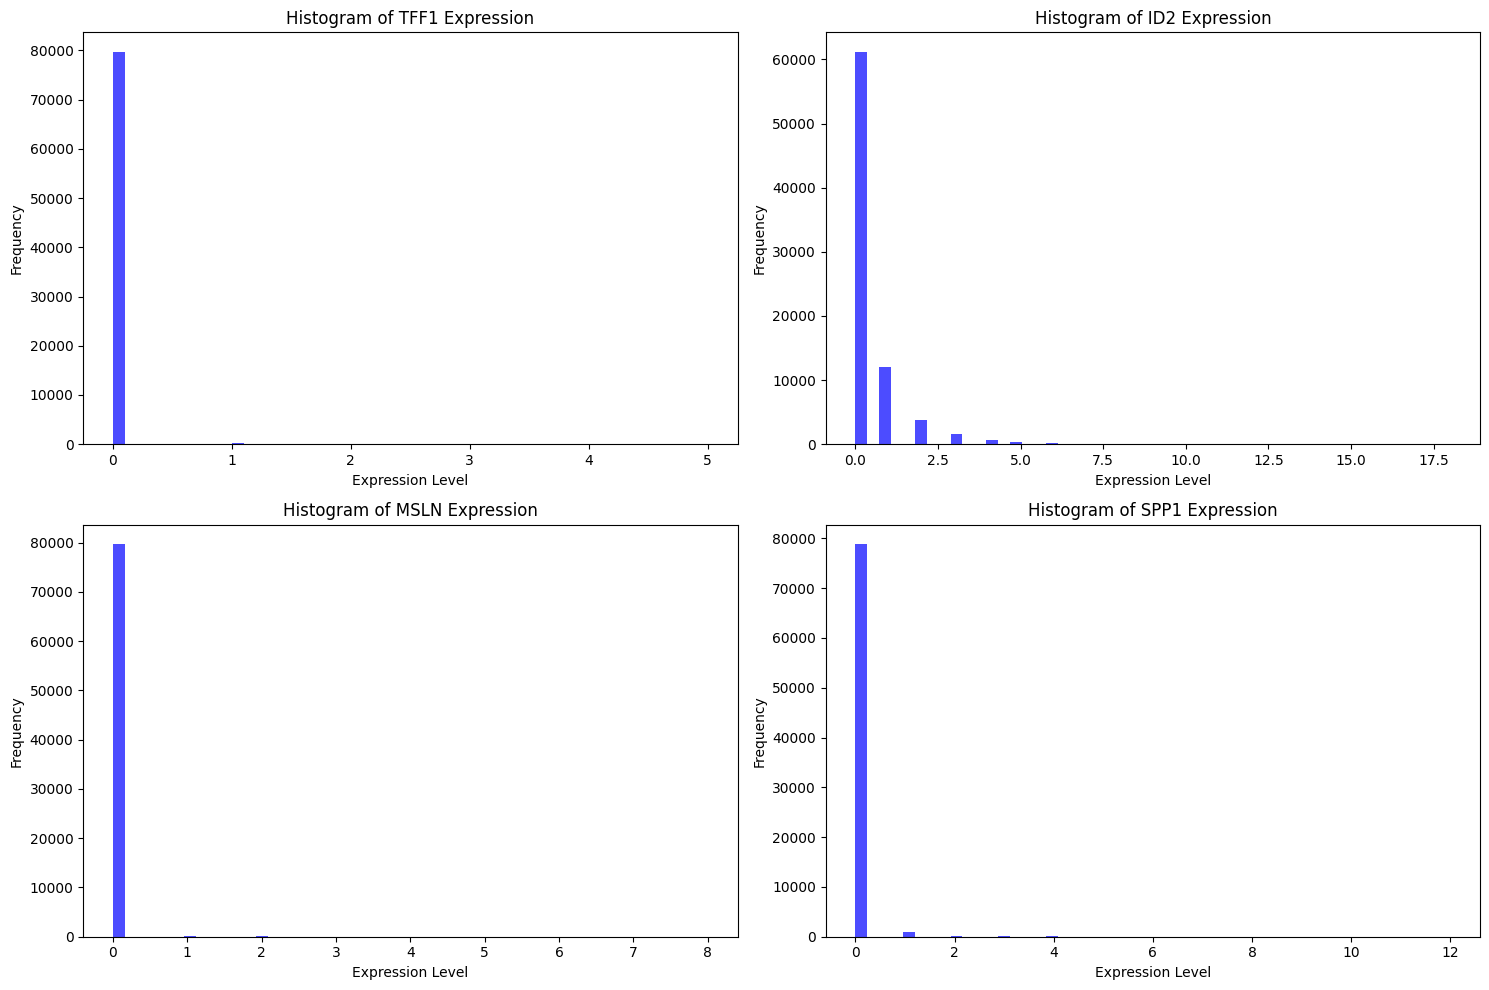

In [34]:
# make some histograms of y to see the distribution of gene expression
# randomly choose 4 genes and make histograms of their expression

import random
# Randomly choose 4 genes
random_genes = random.sample(list(y.columns), 4)

# Plot histograms for the chosen genes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, gene in enumerate(random_genes):
    axes[i].hist(y[gene], bins=50, color='blue', alpha=0.7)
    axes[i].set_title(f'Histogram of {gene} Expression')
    axes[i].set_xlabel('Expression Level')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [35]:
set(y.values.flatten()) # y values are all integers from 0 to 32

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 31,
 32}

In [36]:
# see how well the mean model does on the training set
mean_expression = y.mean(axis=0)
mean_expression = mean_expression.to_numpy()

# calculate the MSE of the mean model
mse = scoring(np.tile(mean_expression, (len(cell_id_example), 1)), y)
print(f"MSE of the mean model: {mse}")


MSE of the mean model: 34080.868412055075


In [38]:
# Check if CUDA is available
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the appropriate device
virchow_wrapper.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(virchow_wrapper.parameters(), lr=0.001)

# Train the model
num_epochs = 5
from tqdm import tqdm
for epoch in range(num_epochs):
    for i, (images, expressions) in tqdm(enumerate(dataloader)):
        # Move data to the appropriate device
        images = images.to(device)
        expressions = expressions.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        outputs = virchow_wrapper(images)
        loss = criterion(outputs, expressions.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')
    
    # Save the model parameters
    torch.save(virchow_wrapper.state_dict(), f'virchow_wrapper_epoch_{epoch+1}.pth')

Using device: mps


100it [02:28,  1.53s/it]

Epoch [1/5], Step [100/2502], Loss: 0.4121


200it [05:01,  1.76s/it]

Epoch [1/5], Step [200/2502], Loss: 0.4251


300it [07:54,  1.84s/it]

Epoch [1/5], Step [300/2502], Loss: 0.3379


400it [10:46,  1.80s/it]

Epoch [1/5], Step [400/2502], Loss: 0.2765


500it [13:37,  1.80s/it]

Epoch [1/5], Step [500/2502], Loss: 0.4916


600it [16:30,  1.83s/it]

Epoch [1/5], Step [600/2502], Loss: 0.3709


700it [19:30,  1.88s/it]

Epoch [1/5], Step [700/2502], Loss: 0.2991


775it [21:46,  1.69s/it]


KeyboardInterrupt: 

In [ ]:
# run the model on the training set and score it
model_output = np.zeros(y.shape)
for i, (images, expressions) in enumerate(dataloader):
    images = {k: v.to(device) for k, v in images.items()}
    outputs = virchow_wrapper(images)
    model_output[i*32:(i+1)*32] = outputs.detach().cpu().numpy()

model_output = pd.DataFrame(model_output, columns=y.columns, index=y.index)
mse = scoring(model_output, y)
print(f"MSE of the model: {mse}")

MSE of the model: 41414.556113630664
